In [1]:
import pandas as pd
import numpy as np

import env
import os

# Acquire

Creating a function to pull in Zillow Data from SQL database

In [2]:
def get_zillow(force_new=False):
    '''
    This function acquires the requisite zillow data from the Codeup SQL database and caches it locally it for future use in a csv 
    document; once the data is accessed the function then returns it as a dataframe.
    
    Arguments: force_new = Set to False by default; if set to true will force a pull from the SQL database and cache a local copy;
    this will overwrite any previously locally cached copy.
    
    Returns: A zillow dataframe ready to use.
    '''
    filename = "zillow.csv"
    query = '''
            SELECT 
                p.parcelid,
                airconditioningtypeid,
                architecturalstyletypeid,
                basementsqft,
                bathroomcnt,
                bedroomcnt,
                buildingclasstypeid,
                buildingqualitytypeid,
                calculatedbathnbr,
                decktypeid,
                finishedfloor1squarefeet,
                calculatedfinishedsquarefeet,
                finishedsquarefeet12,
                finishedsquarefeet13,
                finishedsquarefeet15,
                finishedsquarefeet50,
                finishedsquarefeet6,
                fips,
                fireplacecnt,
                fullbathcnt,
                garagecarcnt,
                garagetotalsqft,
                hashottuborspa,
                heatingorsystemtypeid,
                latitude,
                longitude,
                lotsizesquarefeet,
                poolcnt,
                poolsizesum,
                pooltypeid10,
                pooltypeid2,
                pooltypeid7,
                propertycountylandusecode,
                propertylandusetypeid,
                propertyzoningdesc,
                rawcensustractandblock,
                regionidcity,
                regionidcounty,
                regionidneighborhood,
                regionidzip,
                roomcnt,
                storytypeid,
                threequarterbathnbr,
                typeconstructiontypeid,
                unitcnt,
                yardbuildingsqft17,
                yardbuildingsqft26,
                yearbuilt,
                numberofstories,
                fireplaceflag,
                structuretaxvaluedollarcnt,
                taxvaluedollarcnt,
                assessmentyear,
                landtaxvaluedollarcnt,
                taxamount,
                taxdelinquencyflag,
                taxdelinquencyyear,
                censustractandblock,
                propertylandusedesc,
                logerror,
                p.transactiondate
            FROM
                (SELECT predictions_2017.parcelid, 
                        MAX(transactiondate) AS max_date
                FROM predictions_2017
                GROUP
                BY parcelid) AS m
            JOIN predictions_2017 as p
                ON p.parcelid = m.parcelid
                AND p.transactiondate = m.max_date
            JOIN
                properties_2017 ON properties_2017.parcelid = p.parcelid
            JOIN
                propertylandusetype USING (propertylandusetypeid)
            Where
                propertylandusedesc = 'Single Family Residential' AND 
                transactiondate LIKE '2017-%%'
            ;   
        '''
    url = env.get_db_url('zillow')
    
    if force_new == True:
        df = pd.read_sql(query, url)
        df.to_csv(filename, index = False)
    else:
        if os.path.isfile(filename):
            return pd.read_csv(filename)
        else:
            df = pd.read_sql(query, url)
            df.to_csv(filename, index = False)

    return df 

In [3]:
df = get_zillow()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52319 non-null  int64  
 1   airconditioningtypeid         13615 non-null  float64
 2   architecturalstyletypeid      70 non-null     float64
 3   basementsqft                  47 non-null     float64
 4   bathroomcnt                   52319 non-null  float64
 5   bedroomcnt                    52319 non-null  float64
 6   buildingclasstypeid           0 non-null      float64
 7   buildingqualitytypeid         33654 non-null  float64
 8   calculatedbathnbr             52184 non-null  float64
 9   decktypeid                    389 non-null    float64
 10  finishedfloor1squarefeet      4371 non-null   float64
 11  calculatedfinishedsquarefeet  52238 non-null  float64
 12  finishedsquarefeet12          52073 non-null  float64
 13  f

# Prepare

As seen above, lots of columns are full of nullswill need to write a function to remove columns will nulls above a certain threshold.

In [5]:
def drop_undesired(df, prop_required_column = .95, prop_required_row = .95):
    ''' This function takes in a dataframe and drops columns based on whether it meets the threshold for having values
    in the column and not null values. It then drops any rows based on whether it meets the threshold for having enough
    values in the row.
    
    Arguments: df - a dataframe
                prop_required_column - the proportion of a given column that must be filled by values and not nulls
                prop_required_row - the proportion of a given row that must be filled by values and not nulls
    Returns: a dataframe which no longer has the rows and columns dropped that didn't meet the threshhold.
    '''
    for column in df.columns.tolist():
        if 1-(df[column].isna().sum() / len(df)) < prop_required_column:
            df = df.drop(column, axis = 1)
            
    for row in range(len(df)):
        if 1-(df.loc[row].isna().sum() / len(df.loc[row])) < prop_required_row:
            df = df.drop(row, axis=0)
    return df

In [6]:
df = drop_undesired(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52075 entries, 0 to 52318
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52075 non-null  int64  
 1   bathroomcnt                   52075 non-null  float64
 2   bedroomcnt                    52075 non-null  float64
 3   calculatedbathnbr             52075 non-null  float64
 4   calculatedfinishedsquarefeet  52075 non-null  float64
 5   finishedsquarefeet12          51936 non-null  float64
 6   fips                          52075 non-null  float64
 7   fullbathcnt                   52075 non-null  float64
 8   latitude                      52075 non-null  float64
 9   longitude                     52075 non-null  float64
 10  lotsizesquarefeet             51798 non-null  float64
 11  propertycountylandusecode     52075 non-null  object 
 12  propertylandusetypeid         52075 non-null  float64
 13  r

Out of the original 61 columns I kept 28. And out of the orignal 52319 entries, I retain 52075.

I can immeadiately drop parcelid as this is merely a number identifier and holds no useful information. And I can drop propertylandusedesc as well as all of those will be "Single Family Residential" as per my SQL query above. Further assessmentyear is all the same year 2016.

In [8]:
df.drop(columns=['parcelid', 'propertylandusedesc','assessmentyear'], inplace=True)

I now need to determine what to do with the remaining nulls. I will findout how many each column has.

In [9]:
df.isna().sum()

bathroomcnt                       0
bedroomcnt                        0
calculatedbathnbr                 0
calculatedfinishedsquarefeet      0
finishedsquarefeet12            139
fips                              0
fullbathcnt                       0
latitude                          0
longitude                         0
lotsizesquarefeet               277
propertycountylandusecode         0
propertylandusetypeid             0
rawcensustractandblock            0
regionidcity                    969
regionidcounty                    0
regionidzip                       1
roomcnt                           0
yearbuilt                        25
structuretaxvaluedollarcnt       57
taxvaluedollarcnt                 0
landtaxvaluedollarcnt             0
taxamount                         3
censustractandblock              45
logerror                          0
transactiondate                   0
dtype: int64

In [10]:
columns_to_investigate = ['finishedsquarefeet12','lotsizesquarefeet', 'regionidcity', 'structuretaxvaluedollarcnt', 'yearbuilt','censustractandblock','taxamount']

In [11]:
df[['finishedsquarefeet12','calculatedfinishedsquarefeet']]

,finishedsquarefeet12,calculatedfinishedsquarefeet
0,3100.0,3100.0
1,1465.0,1465.0
2,1243.0,1243.0
3,2376.0,2376.0
4,2962.0,2962.0
...,...,...
52314,1633.0,1633.0
52315,1286.0,1286.0
52316,1612.0,1612.0
52317,1032.0,1032.0


In [12]:
df[df.finishedsquarefeet12 != df.calculatedfinishedsquarefeet].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 411 to 51635
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   139 non-null    float64
 1   bedroomcnt                    139 non-null    float64
 2   calculatedbathnbr             139 non-null    float64
 3   calculatedfinishedsquarefeet  139 non-null    float64
 4   finishedsquarefeet12          0 non-null      float64
 5   fips                          139 non-null    float64
 6   fullbathcnt                   139 non-null    float64
 7   latitude                      139 non-null    float64
 8   longitude                     139 non-null    float64
 9   lotsizesquarefeet             139 non-null    float64
 10  propertycountylandusecode     139 non-null    object 
 11  propertylandusetypeid         139 non-null    float64
 12  rawcensustractandblock        139 non-null    float64
 13  r

It seems here that finishedsquarefeet12 is the same as calculatedfinishedsquarefeet in all but 139 values; in those 139 cases the values are all nulls. This tells me the finishedsquarefeet12 column is useless and I can drop it.

In [13]:
df.drop('finishedsquarefeet12', axis =1, inplace=True)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52075 entries, 0 to 52318
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   52075 non-null  float64
 1   bedroomcnt                    52075 non-null  float64
 2   calculatedbathnbr             52075 non-null  float64
 3   calculatedfinishedsquarefeet  52075 non-null  float64
 4   fips                          52075 non-null  float64
 5   fullbathcnt                   52075 non-null  float64
 6   latitude                      52075 non-null  float64
 7   longitude                     52075 non-null  float64
 8   lotsizesquarefeet             51798 non-null  float64
 9   propertycountylandusecode     52075 non-null  object 
 10  propertylandusetypeid         52075 non-null  float64
 11  rawcensustractandblock        52075 non-null  float64
 12  regionidcity                  51106 non-null  float64
 13  r

In [15]:
df[df.lotsizesquarefeet.isna()].describe()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,...,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
count,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,2.770000e+02,2.770000e+02,0.0,277.0,...,277.000000,277.000000,277.000000,277.000000,2.770000e+02,2.770000e+02,2.770000e+02,277.000000,2.770000e+02,277.000000
mean,3.016245,3.314079,3.016245,2424.790614,6040.256318,2.996390,3.411227e+07,-1.181990e+08,NaN,261.0,...,2832.353791,96479.162455,0.418773,1980.805054,3.469879e+05,9.313854e+05,5.843975e+05,11849.395054,6.040941e+13,0.028932
std,1.723323,1.495979,1.723323,1721.660908,7.826655,1.739353,3.137970e+05,2.645224e+05,NaN,0.0,...,645.699030,409.799508,1.281731,33.929780,3.762735e+05,3.020443e+06,2.968346e+06,36010.193016,8.086563e+10,0.187082
min,1.000000,0.000000,1.000000,470.000000,6037.000000,1.000000,3.334062e+07,-1.187729e+08,NaN,261.0,...,1286.000000,95983.000000,0.000000,1885.000000,1.015000e+03,5.600000e+04,1.120000e+04,835.820000,6.037101e+13,-0.732328
25%,2.000000,2.000000,2.000000,1244.000000,6037.000000,2.000000,3.396847e+07,-1.184113e+08,NaN,261.0,...,3101.000000,96122.000000,0.000000,1956.000000,9.112300e+04,2.323660e+05,1.005620e+05,3039.440000,6.037213e+13,-0.019260
50%,3.000000,3.000000,3.000000,2110.000000,6037.000000,3.000000,3.410265e+07,-1.182490e+08,NaN,261.0,...,3101.000000,96375.000000,0.000000,1990.000000,2.485280e+05,4.941090e+05,2.366340e+05,6939.580000,6.037550e+13,0.016173
75%,4.000000,4.000000,4.000000,3054.000000,6037.000000,4.000000,3.431196e+07,-1.180090e+08,NaN,261.0,...,3101.000000,96531.000000,0.000000,2011.000000,4.244120e+05,9.230300e+05,4.525000e+05,12629.340000,6.037920e+13,0.048829
max,18.000000,14.000000,18.000000,18654.000000,6059.000000,18.000000,3.471825e+07,-1.176441e+08,NaN,261.0,...,3101.000000,97330.000000,7.000000,2015.000000,2.377173e+06,4.906124e+07,4.895220e+07,586639.300000,6.071002e+13,2.348417


No discernable pattern so I will simply drop all rows with nulls as this column is to valuable a feature to just throw away.

In [16]:
# df.drop(df.lotsizesquarefeet.isna(), axis=0)

In [17]:
df = df[df.lotsizesquarefeet.notnull()]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51798 entries, 0 to 52318
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   51798 non-null  float64
 1   bedroomcnt                    51798 non-null  float64
 2   calculatedbathnbr             51798 non-null  float64
 3   calculatedfinishedsquarefeet  51798 non-null  float64
 4   fips                          51798 non-null  float64
 5   fullbathcnt                   51798 non-null  float64
 6   latitude                      51798 non-null  float64
 7   longitude                     51798 non-null  float64
 8   lotsizesquarefeet             51798 non-null  float64
 9   propertycountylandusecode     51798 non-null  object 
 10  propertylandusetypeid         51798 non-null  float64
 11  rawcensustractandblock        51798 non-null  float64
 12  regionidcity                  50829 non-null  float64
 13  r

In [19]:
df.isna().sum()

bathroomcnt                       0
bedroomcnt                        0
calculatedbathnbr                 0
calculatedfinishedsquarefeet      0
fips                              0
fullbathcnt                       0
latitude                          0
longitude                         0
lotsizesquarefeet                 0
propertycountylandusecode         0
propertylandusetypeid             0
rawcensustractandblock            0
regionidcity                    969
regionidcounty                    0
regionidzip                       1
roomcnt                           0
yearbuilt                        25
structuretaxvaluedollarcnt       57
taxvaluedollarcnt                 0
landtaxvaluedollarcnt             0
taxamount                         3
censustractandblock              45
logerror                          0
transactiondate                   0
dtype: int64

Since the value of nulls yearbuilt and structuretaxvaluedollarcnt, taxamount are all so small, I'm going to go ahead and drop those.

In [20]:
df = df[df.yearbuilt.notnull() & df.taxamount.notnull() & df.structuretaxvaluedollarcnt.notnull()]

In [21]:
df.isna().sum()

bathroomcnt                       0
bedroomcnt                        0
calculatedbathnbr                 0
calculatedfinishedsquarefeet      0
fips                              0
fullbathcnt                       0
latitude                          0
longitude                         0
lotsizesquarefeet                 0
propertycountylandusecode         0
propertylandusetypeid             0
rawcensustractandblock            0
regionidcity                    969
regionidcounty                    0
regionidzip                       1
roomcnt                           0
yearbuilt                         0
structuretaxvaluedollarcnt        0
taxvaluedollarcnt                 0
landtaxvaluedollarcnt             0
taxamount                         0
censustractandblock              45
logerror                          0
transactiondate                   0
dtype: int64

I now want to explore the interaction of fips, rgionidcity, regionidcounty, and regionidzip to see if I can understand what regionidcity is telling me and whether I should drop the nulls or drop the entire column.

In [22]:
df[['fips','regionidcity', 'regionidcounty', 'regionidzip']]

,fips,regionidcity,regionidcounty,regionidzip
0,6059.0,53571.0,1286.0,96978.0
1,6111.0,13091.0,2061.0,97099.0
2,6059.0,21412.0,1286.0,97078.0
3,6037.0,396551.0,3101.0,96330.0
4,6037.0,47019.0,3101.0,96293.0
...,...,...,...,...
52314,6037.0,30267.0,3101.0,96204.0
52315,6037.0,12447.0,3101.0,96284.0
52316,6111.0,27110.0,2061.0,97116.0
52317,6037.0,36502.0,3101.0,96480.0


In [23]:
df.fips.value_counts(), df.regionidcounty.value_counts()

(6037.0    33402
 6059.0    13979
 6111.0     4332
 Name: fips, dtype: int64,
 3101.0    33402
 1286.0    13979
 2061.0     4332
 Name: regionidcounty, dtype: int64)

regionidcounty is redundant with fips, I will drop one.

In [24]:
df = df.drop(columns='regionidcounty')

In [25]:
df[['fips','regionidcity', 'regionidzip']]

,fips,regionidcity,regionidzip
0,6059.0,53571.0,96978.0
1,6111.0,13091.0,97099.0
2,6059.0,21412.0,97078.0
3,6037.0,396551.0,96330.0
4,6037.0,47019.0,96293.0
...,...,...,...
52314,6037.0,30267.0,96204.0
52315,6037.0,12447.0,96284.0
52316,6111.0,27110.0,97116.0
52317,6037.0,36502.0,96480.0


In [26]:
df.fips.value_counts(), df.regionidcity.value_counts(), df.regionidzip.value_counts()

(6037.0    33402
 6059.0    13979
 6111.0     4332
 Name: fips, dtype: int64,
 12447.0    11275
 5534.0      1762
 40227.0     1487
 46298.0     1420
 16764.0     1077
            ...  
 32927.0        3
 31134.0        2
 36078.0        1
 10815.0        1
 21395.0        1
 Name: regionidcity, Length: 175, dtype: int64,
 97319.0    763
 97318.0    660
 97329.0    563
 97328.0    517
 97118.0    495
           ... 
 95996.0      2
 97092.0      1
 96038.0      1
 96148.0      1
 96467.0      1
 Name: regionidzip, Length: 379, dtype: int64)

In [27]:
df[df.regionidzip.isna()]

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate
12397,2.0,3.0,2.0,1686.0,6111.0,2.0,34374072.0,-119475416.0,5813.0,1110,...,NaN,5.0,1952.0,57271.0,1075583.0,1018312.0,16350.94,6.111001e+13,-0.156173,2017-03-20


Since I already have regional data in the fips column, and from previous modeling I found region data wasn't helpful in predicting taxvalue I'm going to drop regionidcity but keep regionidzip minus the one null entry

In [28]:
df = df.drop(columns='regionidcity')

In [29]:
df = df[df.regionidzip.notnull()]

In [30]:
df.isna().sum()

bathroomcnt                      0
bedroomcnt                       0
calculatedbathnbr                0
calculatedfinishedsquarefeet     0
fips                             0
fullbathcnt                      0
latitude                         0
longitude                        0
lotsizesquarefeet                0
propertycountylandusecode        0
propertylandusetypeid            0
rawcensustractandblock           0
regionidzip                      0
roomcnt                          0
yearbuilt                        0
structuretaxvaluedollarcnt       0
taxvaluedollarcnt                0
landtaxvaluedollarcnt            0
taxamount                        0
censustractandblock             45
logerror                         0
transactiondate                  0
dtype: int64

investigating the difference between censustrackandblock and rawcensustractandblock

In [31]:
census = df[df['censustractandblock'].isna()]

In [32]:
census.rawcensustractandblock.value_counts()

6.059032e+07    5
6.059063e+07    2
6.111001e+07    2
6.059052e+07    2
6.059099e+07    2
6.059052e+07    2
6.111001e+07    2
6.059052e+07    2
6.059022e+07    1
6.059052e+07    1
6.037901e+07    1
6.037901e+07    1
6.111006e+07    1
6.037901e+07    1
6.037670e+07    1
6.037910e+07    1
6.059052e+07    1
6.111000e+07    1
6.059099e+07    1
6.037900e+07    1
6.111005e+07    1
6.059063e+07    1
6.037900e+07    1
6.059032e+07    1
6.059052e+07    1
6.111005e+07    1
6.059002e+07    1
6.059022e+07    1
6.059063e+07    1
6.037800e+07    1
6.059064e+07    1
6.059012e+07    1
6.037403e+07    1
6.059063e+07    1
Name: rawcensustractandblock, dtype: int64

This data looks weird like it almost all represents the same data, plus it looks like it represents the same data in censustractandblock but scaled differently. Upon further investigation censustract and block data is merely categorical data that is an id given to a parcel of land so I'm going to just drop both rawcensustractandblock and the censustractandblock column

https://www.census.gov/newsroom/blogs/random-samplings/2011/07/what-are-census-blocks.html

In [33]:
df = df.drop(columns= ['censustractandblock', 'rawcensustractandblock'])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51712 entries, 0 to 52318
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   51712 non-null  float64
 1   bedroomcnt                    51712 non-null  float64
 2   calculatedbathnbr             51712 non-null  float64
 3   calculatedfinishedsquarefeet  51712 non-null  float64
 4   fips                          51712 non-null  float64
 5   fullbathcnt                   51712 non-null  float64
 6   latitude                      51712 non-null  float64
 7   longitude                     51712 non-null  float64
 8   lotsizesquarefeet             51712 non-null  float64
 9   propertycountylandusecode     51712 non-null  object 
 10  propertylandusetypeid         51712 non-null  float64
 11  regionidzip                   51712 non-null  float64
 12  roomcnt                       51712 non-null  float64
 13  y

No nulls left, need to check and see if these values make sense now or if I need to drop any nonsense data.

In [35]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,51712.0,2.299843e+00,1.009360,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.300000e+01
bedroomcnt,51712.0,3.307375e+00,0.931480,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
calculatedbathnbr,51712.0,2.299843e+00,1.009360,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.300000e+01
calculatedfinishedsquarefeet,51712.0,1.918925e+03,994.076306,1.520000e+02,1.268000e+03,1.657000e+03,2.301000e+03,2.192900e+04
fips,51712.0,6.049145e+03,21.023247,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
fullbathcnt,51712.0,2.234278e+00,0.983914,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.300000e+01
latitude,51712.0,3.402187e+07,273642.469522,3.334085e+07,3.382662e+07,3.402175e+07,3.418674e+07,3.481877e+07
longitude,51712.0,-1.181934e+08,356543.369732,-1.194753e+08,-1.183996e+08,-1.181522e+08,-1.179289e+08,-1.175546e+08
lotsizesquarefeet,51712.0,1.121345e+04,86722.287134,2.360000e+02,5.580000e+03,6.835000e+03,8.771000e+03,6.971010e+06
propertylandusetypeid,51712.0,2.610000e+02,0.000000,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02


Need to get rid or invalid data in bedroomcnt, it's showing homes with 0 bedrooms.

In [36]:
df = df[df.bedroomcnt != 0]

Further, it's showing minimum roomcnt at 0 and upon investigation this is the majority of the data. So I will drop this column.

In [37]:
df = df.drop(columns = 'roomcnt')

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,51684.0,2.300132e+00,1.009310,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.300000e+01
bedroomcnt,51684.0,3.309167e+00,0.928544,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
calculatedbathnbr,51684.0,2.300132e+00,1.009310,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.300000e+01
calculatedfinishedsquarefeet,51684.0,1.919109e+03,993.953170,1.520000e+02,1.269000e+03,1.657000e+03,2.301000e+03,2.192900e+04
fips,51684.0,6.049144e+03,21.018600,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
fullbathcnt,51684.0,2.234541e+00,0.983867,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.300000e+01
latitude,51684.0,3.402183e+07,273687.182912,3.334085e+07,3.382656e+07,3.402157e+07,3.418675e+07,3.481877e+07
longitude,51684.0,-1.181933e+08,356521.258234,-1.194753e+08,-1.183996e+08,-1.181519e+08,-1.179289e+08,-1.175546e+08
lotsizesquarefeet,51684.0,1.121034e+04,86745.262564,2.360000e+02,5.580000e+03,6.834000e+03,8.769000e+03,6.971010e+06
propertylandusetypeid,51684.0,2.610000e+02,0.000000,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02


In [39]:
df.calculatedfinishedsquarefeet.min()

152.0

This doesn't seem nearly big enough for a house. I will write a function that throws out houses smaller than a theoretical minimum based on number of bedrooms and bathrooms.

In [40]:
def minimum_sqr_ft(df):
    '''
    Function that takes in a dataframe and finds the minimum sq footage necessary given an input number of bathrooms and bedrooms.
    
    Arguments: A dataframe containing bathroomcnt and bedroomcnt columns.

    Returns: a total minimum amount of square feet necessary for a specified house.
    '''
    # min square footage for type of room
    bathroom_min = 10
    bedroom_min = 70
    
    # total MIN sqr feet
    total = (df.bathroomcnt * bathroom_min) + (df.bedroomcnt * bedroom_min)
    # return MIN sqr feet
    return total

def clean_sqr_feet(df):
    '''
    Takes in a dataframe finds the theoretical minimum sq footage given bathroom and bedroom inputs and compares that to the actual
    given sq footage.  
    Returns a dataframe where containing results only having an actual sq footage larger than the calculate minimum.
    '''
    # get MIN sqr ft
    min_sqr_ft = minimum_sqr_ft(df)
    # return df with sqr_ft >= min_sqr_ft
    # change 'sqr_ft' to whichever name you have for sqr_ft in df
    return df[df.calculatedfinishedsquarefeet >= min_sqr_ft]

In [41]:
df = clean_sqr_feet(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51683 entries, 0 to 52318
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   51683 non-null  float64
 1   bedroomcnt                    51683 non-null  float64
 2   calculatedbathnbr             51683 non-null  float64
 3   calculatedfinishedsquarefeet  51683 non-null  float64
 4   fips                          51683 non-null  float64
 5   fullbathcnt                   51683 non-null  float64
 6   latitude                      51683 non-null  float64
 7   longitude                     51683 non-null  float64
 8   lotsizesquarefeet             51683 non-null  float64
 9   propertycountylandusecode     51683 non-null  object 
 10  propertylandusetypeid         51683 non-null  float64
 11  regionidzip                   51683 non-null  float64
 12  yearbuilt                     51683 non-null  float64
 13  s

Now changing fips to 'county' and mapping the county name here.

In [42]:
def map_counties(df):
    # identified counties for fips codes 
    counties = {6037: 'los_angeles',
                6059: 'orange',
                6111: 'ventura'}
    # map counties to fips codes
    df.fips = df.fips.map(counties)
    df.rename(columns=({ 'fips': 'county'}), inplace=True)
    return df

In [43]:
df = map_counties(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51683 entries, 0 to 52318
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   51683 non-null  float64
 1   bedroomcnt                    51683 non-null  float64
 2   calculatedbathnbr             51683 non-null  float64
 3   calculatedfinishedsquarefeet  51683 non-null  float64
 4   county                        51683 non-null  object 
 5   fullbathcnt                   51683 non-null  float64
 6   latitude                      51683 non-null  float64
 7   longitude                     51683 non-null  float64
 8   lotsizesquarefeet             51683 non-null  float64
 9   propertycountylandusecode     51683 non-null  object 
 10  propertylandusetypeid         51683 non-null  float64
 11  regionidzip                   51683 non-null  float64
 12  yearbuilt                     51683 non-null  float64
 13  s

Checking the propertylandusetypeid

In [44]:
df.propertylandusetypeid.value_counts()

261.0    51683
Name: propertylandusetypeid, dtype: int64

I can drop this as it's useless

In [45]:
df.drop(columns = 'propertylandusetypeid', inplace=True)

checking propertycountylandusecode

In [46]:
df.propertycountylandusecode.value_counts()

0100    26389
122     12939
0101     6341
1111     3341
1        1039
1110      984
0104      364
0103       86
010G       63
0108       54
010M       50
0109        8
0113        6
0110        6
0102        3
0105        3
0111        2
0133        1
0131        1
1112        1
0114        1
0130        1
Name: propertycountylandusecode, dtype: int64

After reading about this column and seeing the data, I can't see a use for it now, but it may be useful for clustering and feature engineering later; will leave for now.

In [47]:
df.transactiondate

0        2017-01-01
1        2017-01-01
2        2017-01-01
3        2017-01-01
4        2017-01-01
            ...    
52314    2017-09-19
52315    2017-09-20
52316    2017-09-21
52317    2017-09-21
52318    2017-09-25
Name: transactiondate, Length: 51683, dtype: object

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51683 entries, 0 to 52318
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   51683 non-null  float64
 1   bedroomcnt                    51683 non-null  float64
 2   calculatedbathnbr             51683 non-null  float64
 3   calculatedfinishedsquarefeet  51683 non-null  float64
 4   county                        51683 non-null  object 
 5   fullbathcnt                   51683 non-null  float64
 6   latitude                      51683 non-null  float64
 7   longitude                     51683 non-null  float64
 8   lotsizesquarefeet             51683 non-null  float64
 9   propertycountylandusecode     51683 non-null  object 
 10  regionidzip                   51683 non-null  float64
 11  yearbuilt                     51683 non-null  float64
 12  structuretaxvaluedollarcnt    51683 non-null  float64
 13  t

Time to convert datatypes

In [49]:
for column in df.columns.tolist():
    print(column)
    print(f'Max is {df[column].max()}')
    print(df[column].value_counts())

bathroomcnt
Max is 13.0
2.0     21735
3.0     10521
1.0      9429
2.5      3916
4.0      2151
3.5       909
1.5       824
5.0       770
4.5       681
6.0       300
5.5       223
7.0        87
8.0        51
6.5        47
7.5        16
9.0        12
10.0        5
11.0        3
8.5         2
13.0        1
Name: bathroomcnt, dtype: int64
bedroomcnt
Max is 11.0
3.0     23159
4.0     15063
2.0      8223
5.0      3904
6.0       625
1.0       572
7.0       102
8.0        24
9.0         8
10.0        2
11.0        1
Name: bedroomcnt, dtype: int64
calculatedbathnbr
Max is 13.0
2.0     21735
3.0     10521
1.0      9429
2.5      3916
4.0      2151
3.5       909
1.5       824
5.0       770
4.5       681
6.0       300
5.5       223
7.0        87
8.0        51
6.5        47
7.5        16
9.0        12
10.0        5
11.0        3
8.5         2
13.0        1
Name: calculatedbathnbr, dtype: int64
calculatedfinishedsquarefeet
Max is 21929.0
1120.0    127
1200.0    117
1080.0    101
936.0      86
1040.0  

In [51]:
df.bedroomcnt = df.bedroomcnt.astype('uint8')
df.bathroomcnt = df.bathroomcnt.astype('float16')
df.calculatedbathnbr = df.calculatedbathnbr.astype('float16')
df.yearbuilt = df.yearbuilt.astype('uint16')
df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.astype('uint16')


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51683 entries, 0 to 52318
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   51683 non-null  float16
 1   bedroomcnt                    51683 non-null  uint8  
 2   calculatedbathnbr             51683 non-null  float16
 3   calculatedfinishedsquarefeet  51683 non-null  uint16 
 4   county                        51683 non-null  object 
 5   fullbathcnt                   51683 non-null  float64
 6   latitude                      51683 non-null  float64
 7   longitude                     51683 non-null  float64
 8   lotsizesquarefeet             51683 non-null  float64
 9   propertycountylandusecode     51683 non-null  object 
 10  regionidzip                   51683 non-null  float64
 11  yearbuilt                     51683 non-null  uint16 
 12  structuretaxvaluedollarcnt    51683 non-null  float64
 13  t

Now I need to deal visualize the data simply to help deal with outliers.

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

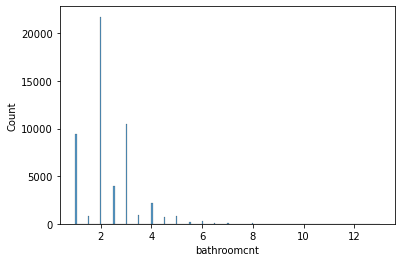

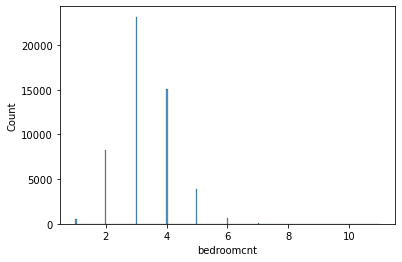

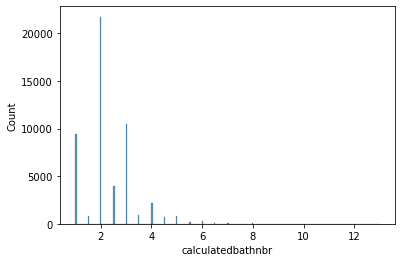

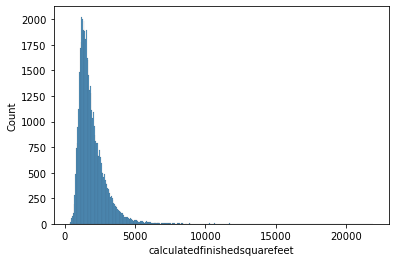

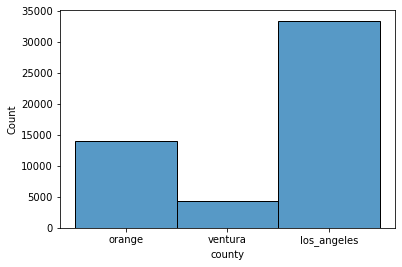

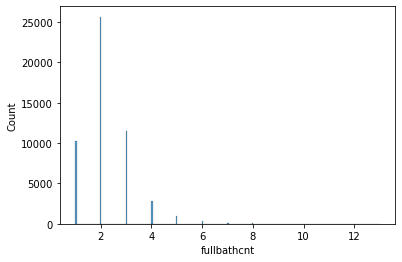

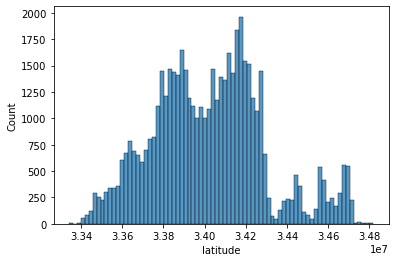

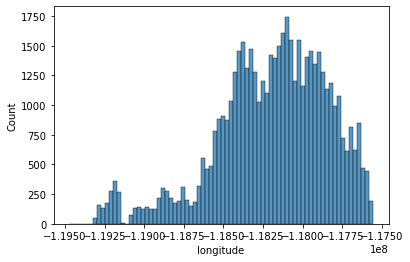

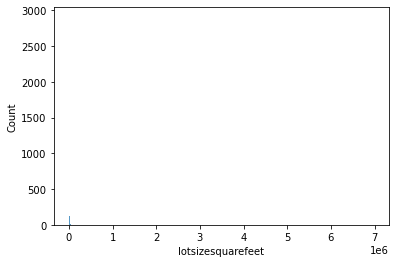

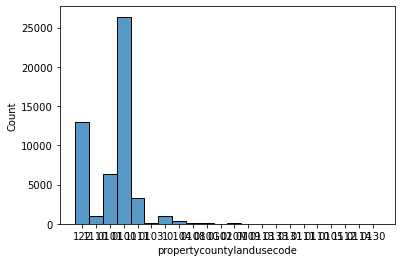

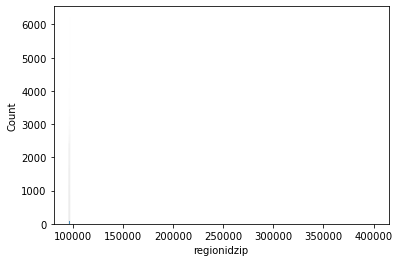

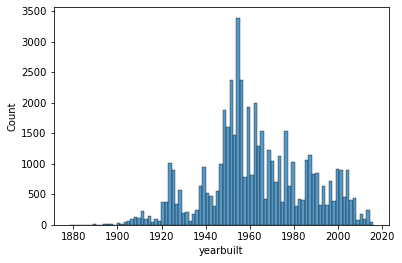

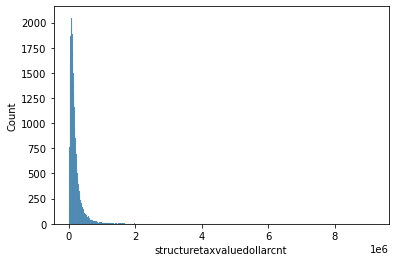

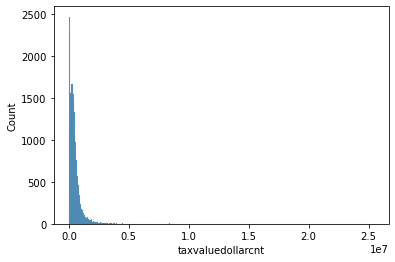

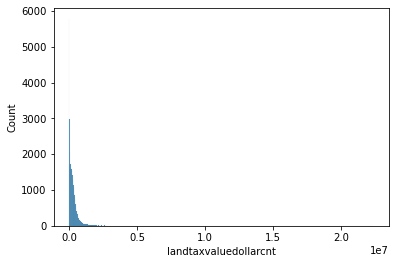

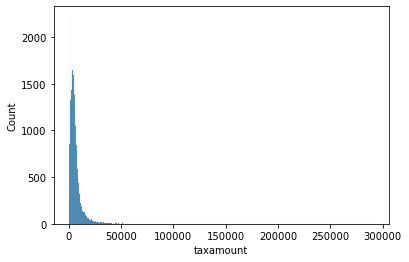

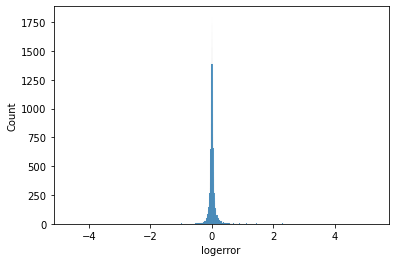

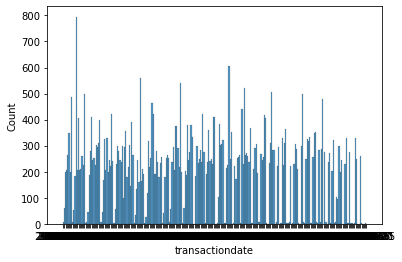

In [54]:
for column in df.columns.tolist():
    sns.histplot(df[column])
    plt.show()

Several columns have major outliers, will use a function to trim down on the biggest 3 categories of outliers first and reevaluate. Tax value, house square footage, lot size square footage

In [55]:
def not_outlier(df_column, thresh=3.5):
    """
    Returns a boolean array with True if points are not outliers and False 
    otherwise.

    Parameters:
    -----------
        df_column : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(df_column.shape) == 1:
        df_column = np.array(df_column).reshape(-1,1)
    median = np.median(df_column, axis=0)
    diff = np.sum((df_column - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score < thresh

In [56]:
dfnew = df[not_outlier(df.taxvaluedollarcnt, thresh=4.5)]
dfnew = dfnew[not_outlier(dfnew.calculatedfinishedsquarefeet, thresh=5)]
dfnew = dfnew[not_outlier(dfnew.lotsizesquarefeet, thresh=4)]
dfnew = dfnew[not_outlier(dfnew.bathroomcnt, thresh=4)]
dfnew = dfnew[not_outlier(dfnew.bedroomcnt, thresh=4)]

In [57]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45381 entries, 0 to 52318
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   45381 non-null  float16
 1   bedroomcnt                    45381 non-null  uint8  
 2   calculatedbathnbr             45381 non-null  float16
 3   calculatedfinishedsquarefeet  45381 non-null  uint16 
 4   county                        45381 non-null  object 
 5   fullbathcnt                   45381 non-null  float64
 6   latitude                      45381 non-null  float64
 7   longitude                     45381 non-null  float64
 8   lotsizesquarefeet             45381 non-null  float64
 9   propertycountylandusecode     45381 non-null  object 
 10  regionidzip                   45381 non-null  float64
 11  yearbuilt                     45381 non-null  uint16 
 12  structuretaxvaluedollarcnt    45381 non-null  float64
 13  t

This reduced the number of entries from 51683 to 44010.

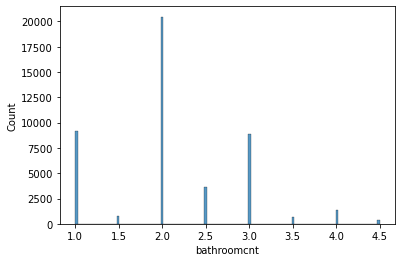

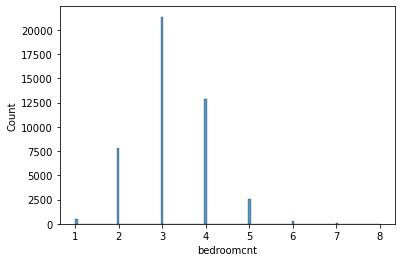

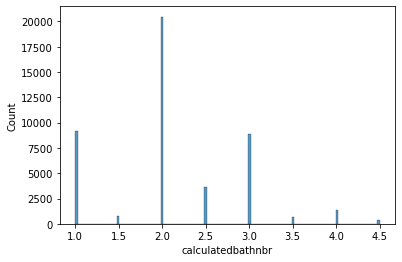

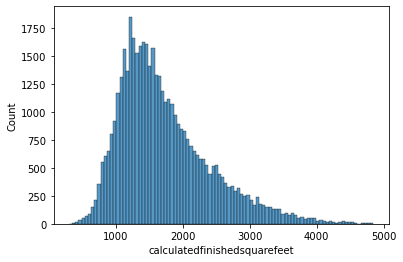

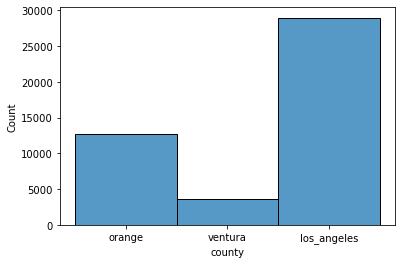

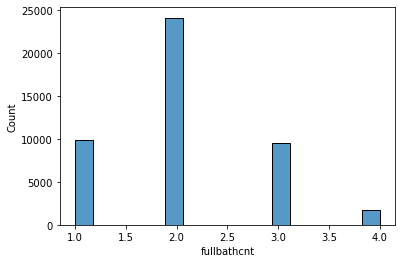

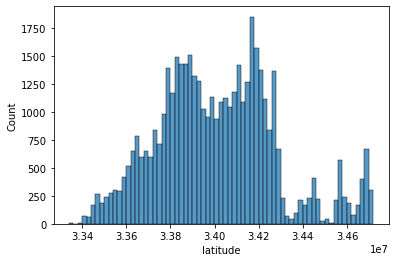

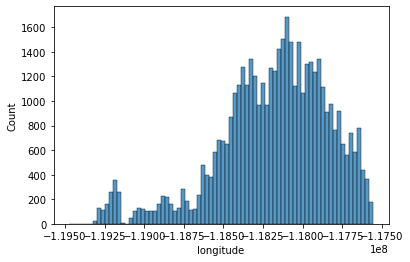

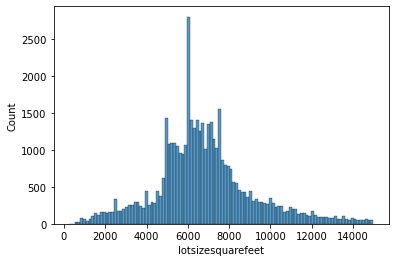

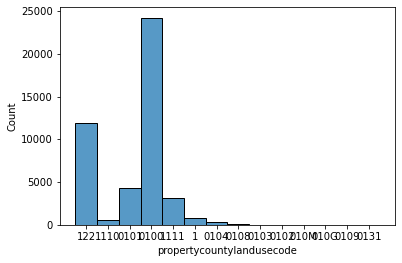

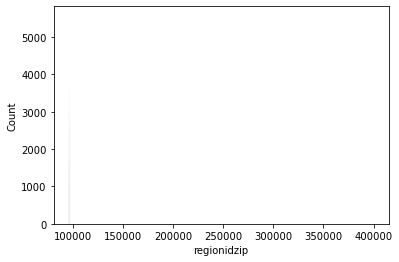

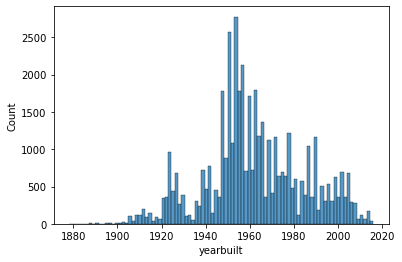

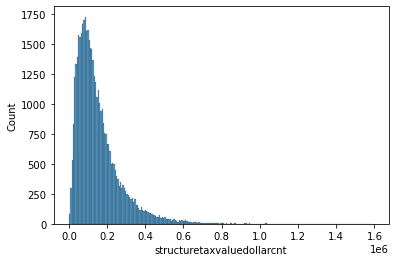

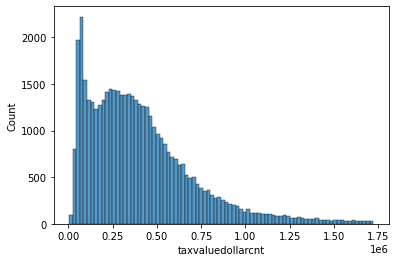

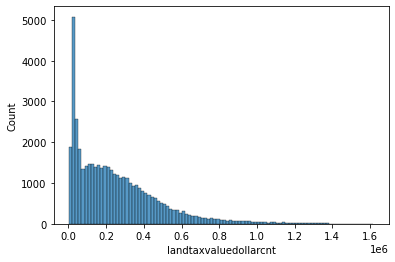

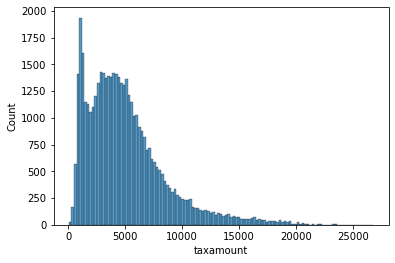

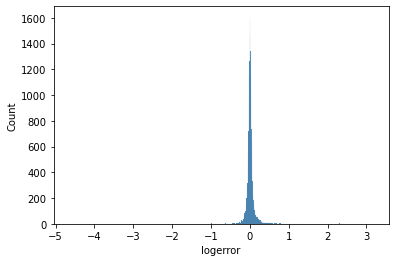

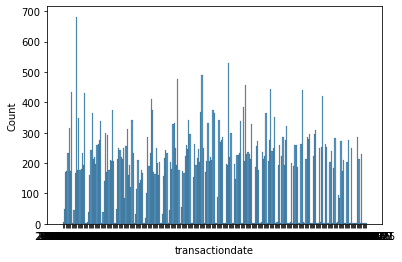

In [58]:
for column in dfnew.columns.tolist():
    sns.histplot(dfnew[column])
    plt.show()

Using the function above I was able to eliminate significant outliers and was left with 45381 entries. This is 85.2% of the previous dataframe that had 51683. I will do my work on this remaining dataset.

Further it is characterized by the following:

In [59]:
for column in dfnew.select_dtypes('number').columns.tolist():
    print(f'{column} max: {dfnew[column].max()}')

bathroomcnt max: 4.5
bedroomcnt max: 8
calculatedbathnbr max: 4.5
calculatedfinishedsquarefeet max: 4845
fullbathcnt max: 4.0
latitude max: 34718356.0
longitude max: -117554636.0
lotsizesquarefeet max: 14991.0
regionidzip max: 399675.0
yearbuilt max: 2016
structuretaxvaluedollarcnt max: 1594102.0
taxvaluedollarcnt max: 1721400.0
landtaxvaluedollarcnt max: 1617388.0
taxamount max: 26802.13
logerror max: 3.1756879667400004


In [60]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45381 entries, 0 to 52318
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   45381 non-null  float16
 1   bedroomcnt                    45381 non-null  uint8  
 2   calculatedbathnbr             45381 non-null  float16
 3   calculatedfinishedsquarefeet  45381 non-null  uint16 
 4   county                        45381 non-null  object 
 5   fullbathcnt                   45381 non-null  float64
 6   latitude                      45381 non-null  float64
 7   longitude                     45381 non-null  float64
 8   lotsizesquarefeet             45381 non-null  float64
 9   propertycountylandusecode     45381 non-null  object 
 10  regionidzip                   45381 non-null  float64
 11  yearbuilt                     45381 non-null  uint16 
 12  structuretaxvaluedollarcnt    45381 non-null  float64
 13  t

In [61]:
dfnew.describe()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror
count,4.538100e+04,45381.000000,4.538100e+04,45381.000000,45381.000000,4.538100e+04,4.538100e+04,45381.000000,45381.000000,45381.000000,4.538100e+04,4.538100e+04,4.538100e+04,45381.000000,45381.000000
mean,inf,3.222318,inf,1730.766532,2.067583,3.401246e+07,-1.181830e+08,6802.940173,96574.343999,1961.977281,1.514642e+05,4.062921e+05,2.548278e+05,5027.193716,0.016752
std,7.827148e-01,0.863975,7.827148e-01,683.603065,0.759945,2.709584e+05,3.524281e+05,2392.431096,1483.409080,22.476903,1.164517e+05,3.019006e+05,2.282805e+05,3512.616824,0.165483
min,1.000000e+00,1.000000,1.000000e+00,300.000000,1.000000,3.334085e+07,-1.194753e+08,236.000000,95982.000000,1878.000000,1.480000e+02,3.254000e+03,2.250000e+03,49.180000,-4.655420
25%,2.000000e+00,3.000000,2.000000e+00,1236.000000,2.000000,3.382145e+07,-1.183806e+08,5403.000000,96206.000000,1950.000000,7.241300e+04,1.804170e+05,6.873200e+04,2522.320000,-0.024276
50%,2.000000e+00,3.000000,2.000000e+00,1574.000000,2.000000,3.399749e+07,-1.181382e+08,6557.000000,96420.000000,1959.000000,1.206640e+05,3.475560e+05,2.022900e+05,4354.850000,0.006015
75%,2.500000e+00,4.000000,2.500000e+00,2085.000000,2.000000,3.418186e+07,-1.179297e+08,7860.000000,96996.000000,1977.000000,1.946910e+05,5.472080e+05,3.679960e+05,6554.580000,0.037333
max,4.500000e+00,8.000000,4.500000e+00,4845.000000,4.000000,3.471836e+07,-1.175546e+08,14991.000000,399675.000000,2016.000000,1.594102e+06,1.721400e+06,1.617388e+06,26802.130000,3.175688


testing wrangle_zillow script file

In [62]:
import wrangle_zillow

In [63]:
df = wrangle_zillow.get_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52319 non-null  int64  
 1   airconditioningtypeid         13615 non-null  float64
 2   architecturalstyletypeid      70 non-null     float64
 3   basementsqft                  47 non-null     float64
 4   bathroomcnt                   52319 non-null  float64
 5   bedroomcnt                    52319 non-null  float64
 6   buildingclasstypeid           0 non-null      float64
 7   buildingqualitytypeid         33654 non-null  float64
 8   calculatedbathnbr             52184 non-null  float64
 9   decktypeid                    389 non-null    float64
 10  finishedfloor1squarefeet      4371 non-null   float64
 11  calculatedfinishedsquarefeet  52238 non-null  float64
 12  finishedsquarefeet12          52073 non-null  float64
 13  f

In [64]:
df = wrangle_zillow.clean_zillow(df)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45381 entries, 0 to 52318
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   45381 non-null  float16
 1   bedroomcnt                    45381 non-null  uint8  
 2   calculatedbathnbr             45381 non-null  float16
 3   calculatedfinishedsquarefeet  45381 non-null  uint16 
 4   county                        45381 non-null  object 
 5   fullbathcnt                   45381 non-null  float64
 6   latitude                      45381 non-null  float64
 7   longitude                     45381 non-null  float64
 8   lotsizesquarefeet             45381 non-null  float64
 9   propertycountylandusecode     45381 non-null  object 
 10  regionidzip                   45381 non-null  float64
 11  yearbuilt                     45381 non-null  uint16 
 12  structuretaxvaluedollarcnt    45381 non-null  float64
 13  t

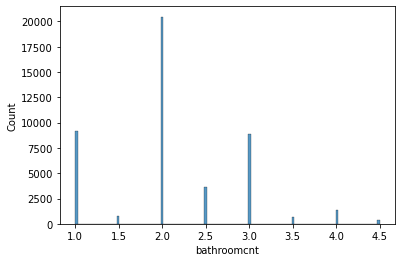

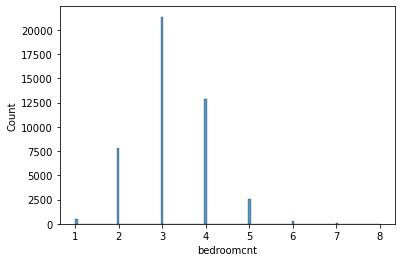

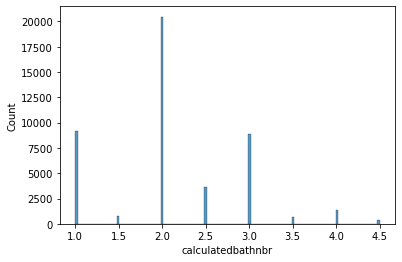

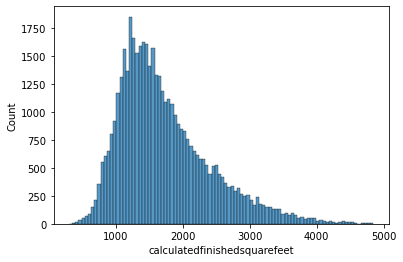

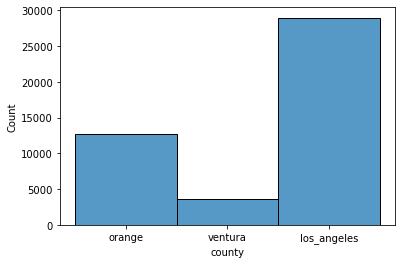

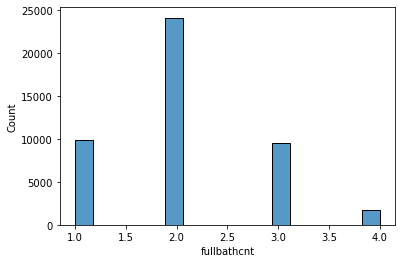

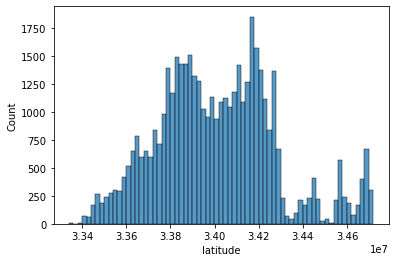

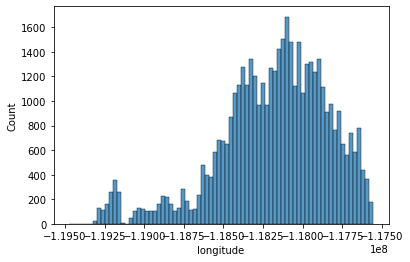

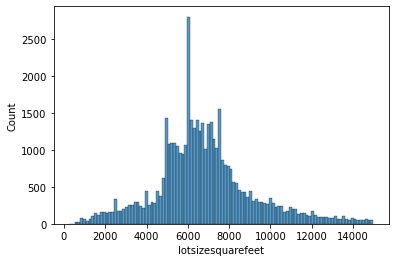

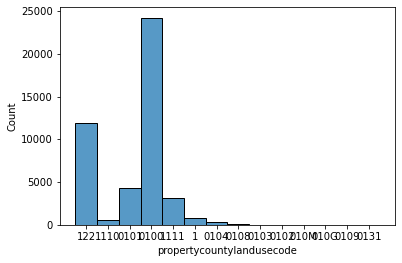

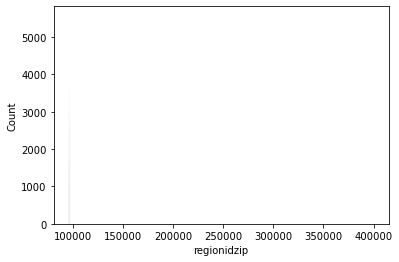

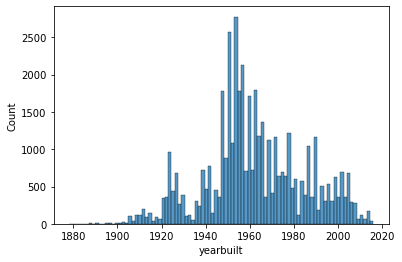

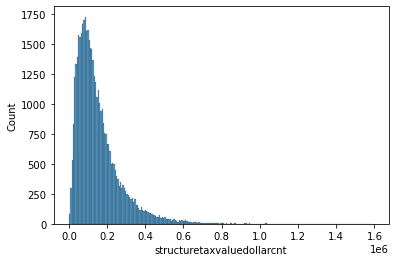

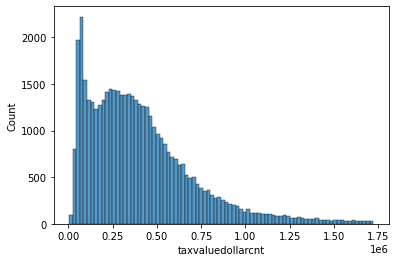

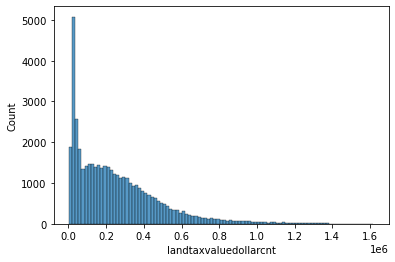

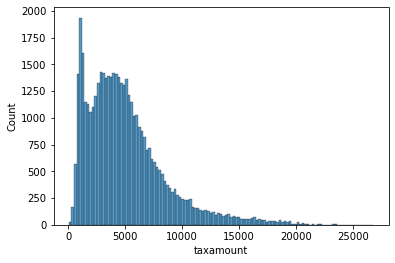

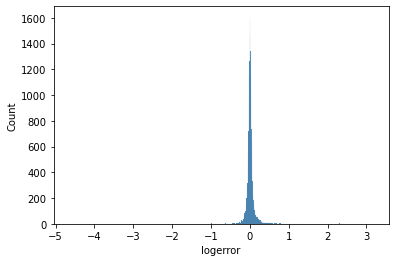

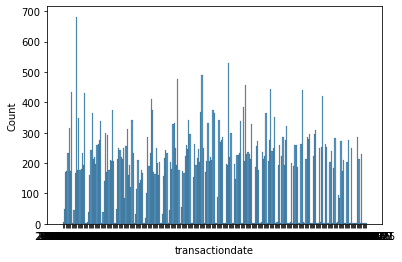

In [66]:
for column in df.columns.tolist():
    sns.histplot(df[column])
    plt.show()

# Prepare part 2

In [67]:
from sklearn.model_selection import train_test_split

def split_zillow(df):
    '''
    Takes in a cleaned zillow dataframe, splits it into train, validate and test subgroups and then returns those subgroups.
    
    Arguments: df - a cleaned pandas dataframe with the expected feature names and columns in the zillow dataset
    Return: train, validate, test - dataframes ready for the exploration and model phases.
    '''
    train, test = train_test_split(df, train_size = 0.8, random_state = 1234)
    train, validate = train_test_split(train, train_size = 0.7, random_state = 1234)
    return train, validate, test

In [68]:
from sklearn.preprocessing import MinMaxScaler

def data_scaler(train, validate, test, columns_to_scale):
    '''
    This function takes in train, validate, test subsets of the cleaned zillow dataset and using the train subset creates a min_max 
    scaler. It thens scales the subsets and returns the train, validate, test subsets as scaled versions of the initial data.

    Arguments:  train, validate, test - split subsets from of the cleaned zillow dataframe
                columns_to_scale - a list of column names to scale
    Return: scaled_train, scaled_validate, scaled_test - dataframe with scaled versions of the initial unscaled dataframes 
    '''
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = MinMaxScaler()
    
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.fit_transform(train[columns_to_scale]), 
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])

    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])

    return train_scaled, validate_scaled, test_scaled

In [69]:
train, validate, test = split_zillow(df)
train.shape, validate.shape, test.shape

((25412, 18), (10892, 18), (9077, 18))

In [70]:
columns_to_scale = df.select_dtypes('number').columns.drop(['latitude', 'longitude','regionidzip', 'logerror'])

In [71]:
train_scaled, validate_scaled, test_scaled = data_scaler(train, validate, test, columns_to_scale)

In [72]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((25412, 18), (10892, 18), (9077, 18))

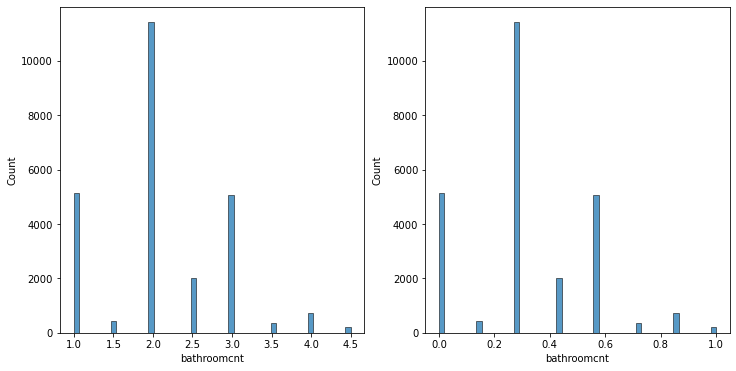

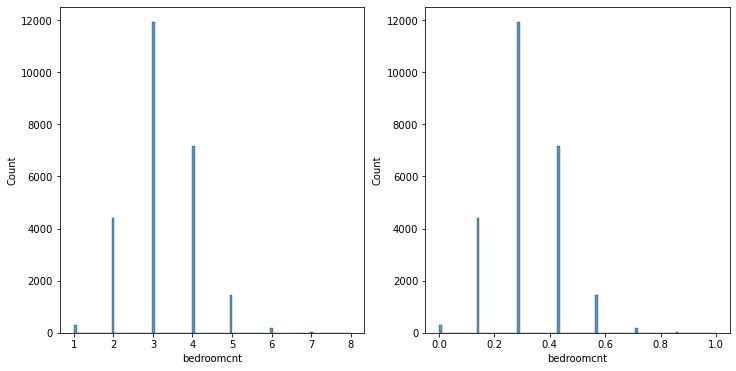

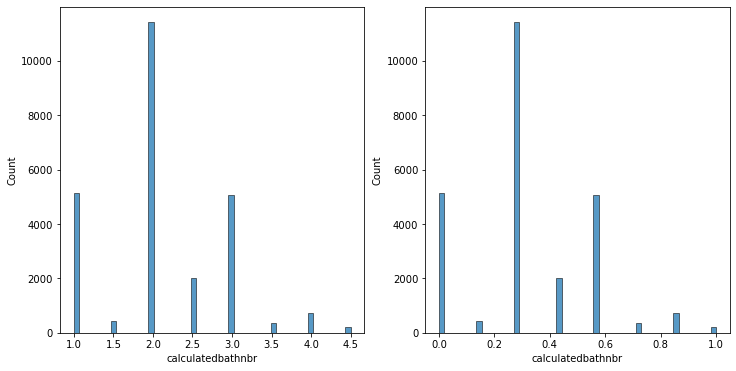

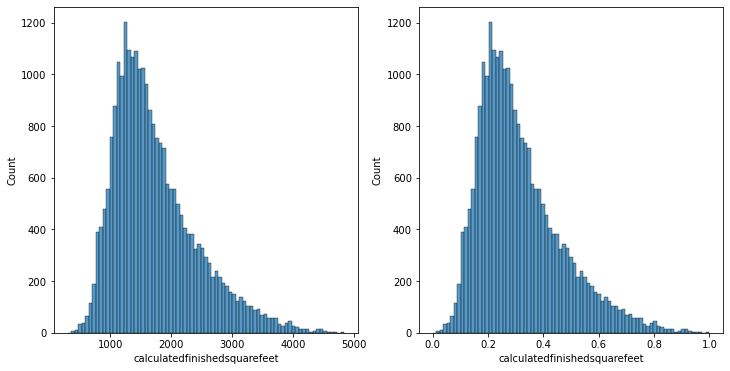

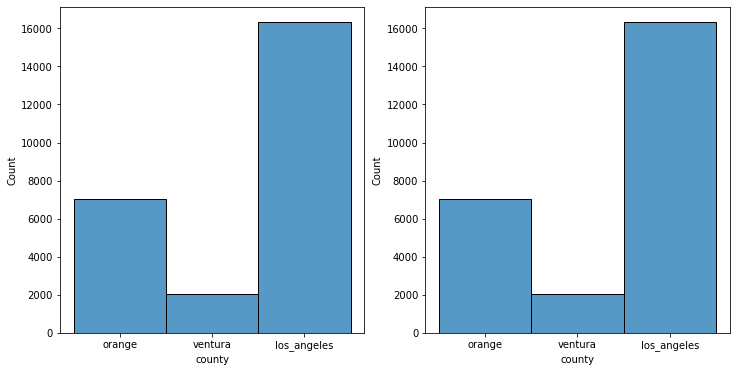

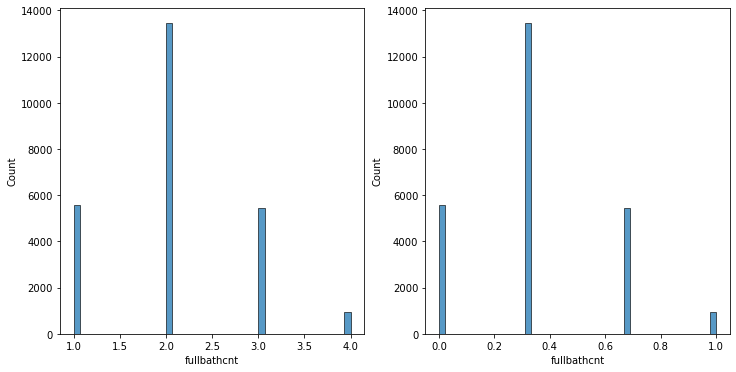

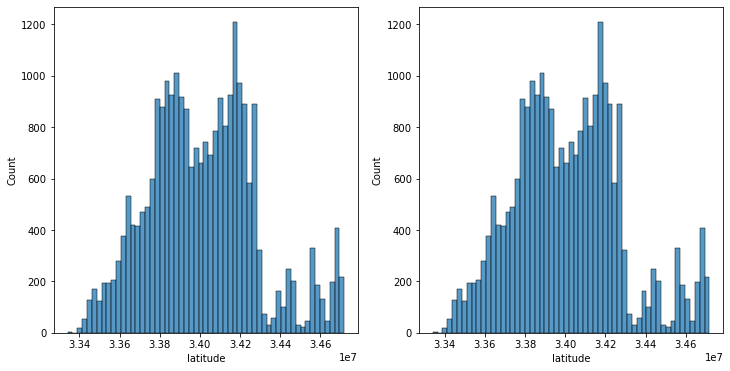

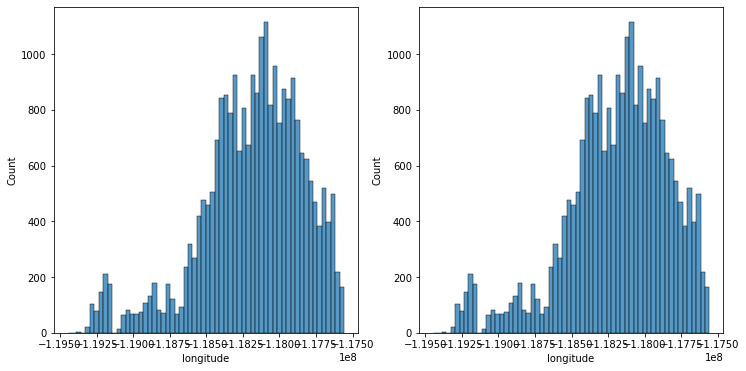

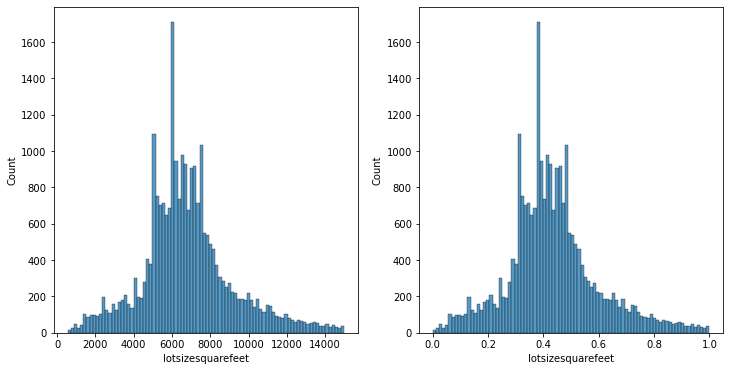

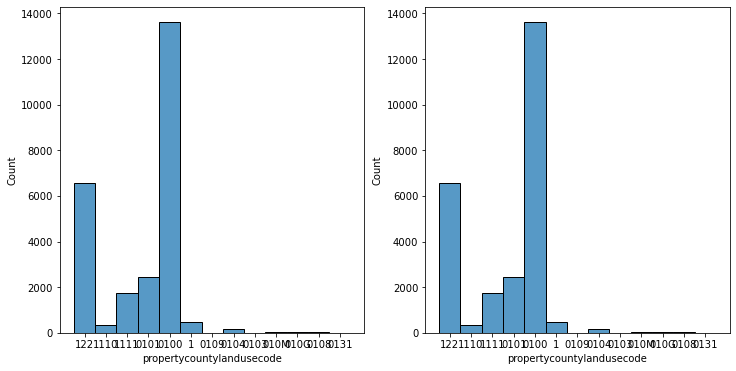

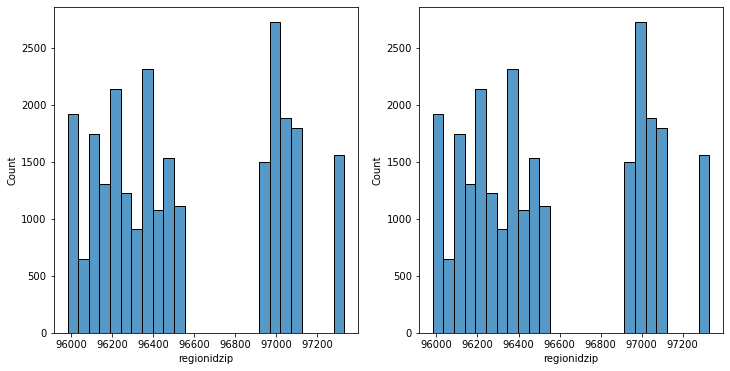

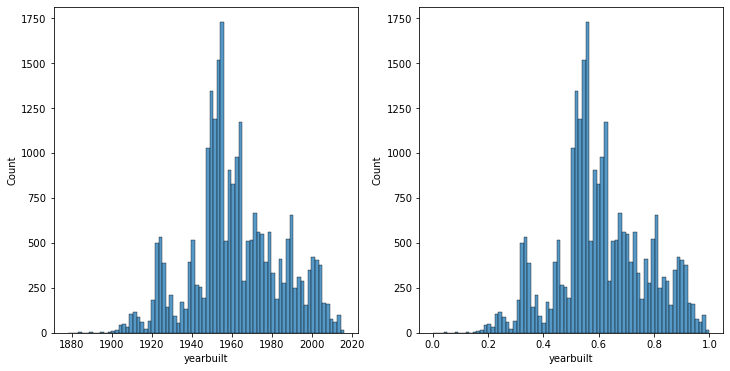

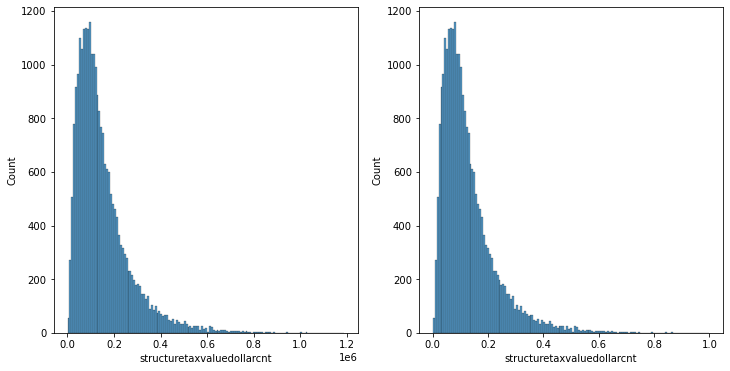

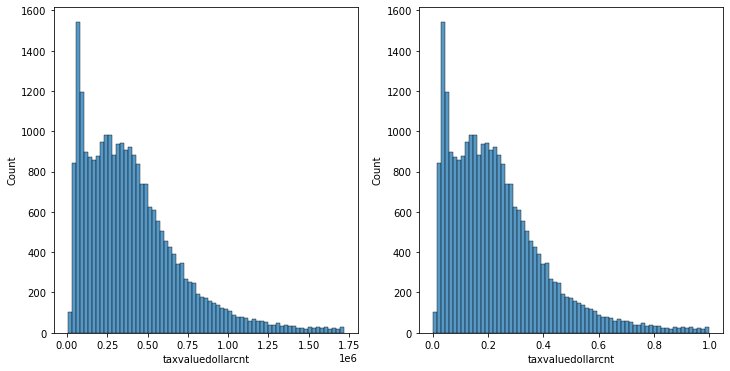

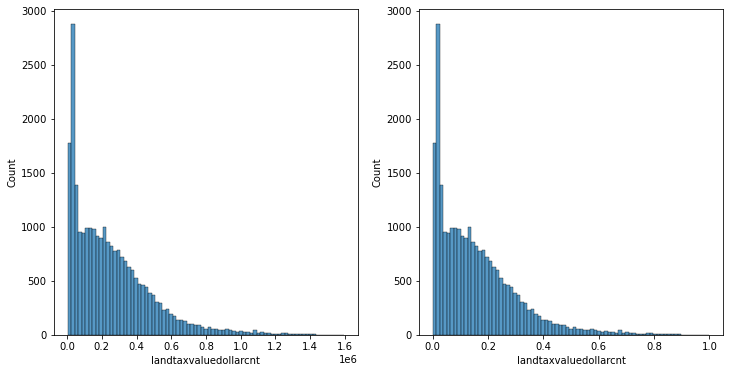

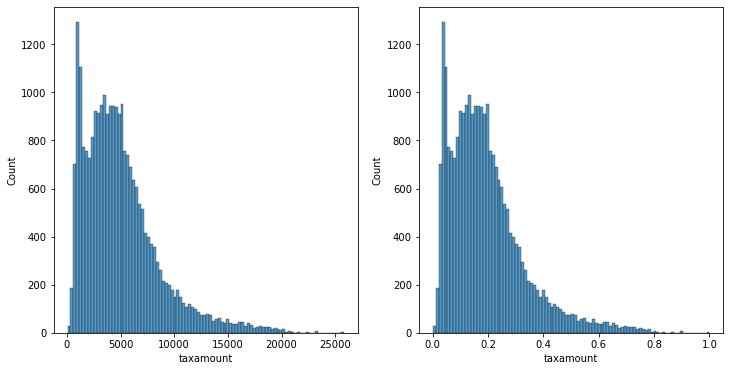

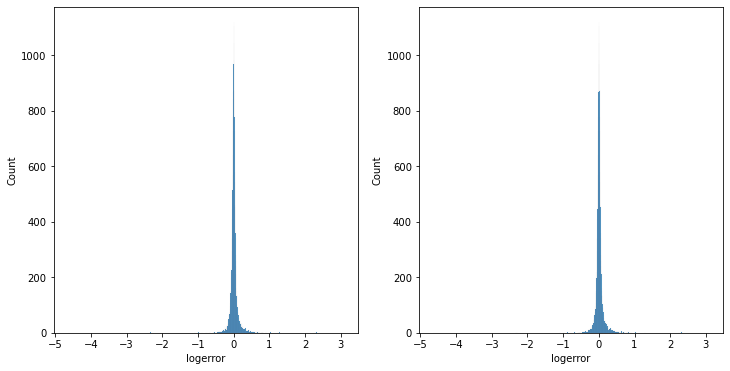

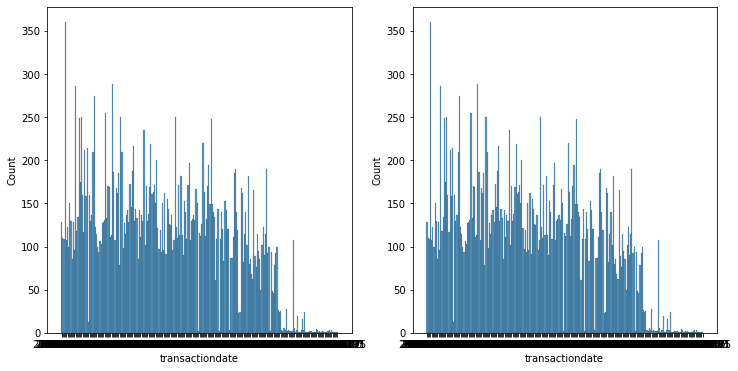

In [73]:
for column in train.columns.tolist():
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    sns.histplot(train[column])
    plt.subplot(122)
    sns.histplot(train_scaled[column])
    plt.show()

Data is now appropriately scaled where needed.

Finished Wrangle. Put all code into wrangle.py